<a href="https://colab.research.google.com/github/jigjid/github_task/blob/main/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence to sequence example in Keras (character-level).

This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

## Summary of the algorithm:

- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.

## Data download:

English to French sentence pairs.
https://www.manythings.org/anki/fra-eng.zip

Lots of neat sentence pairs datasets can be found at:
https://www.manythings.org/anki/

## References:

- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078

## **【Problem 1】** Machine translation execution and code reading

In [ ]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

- line 1-4: Import library

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

- Line 1-4: hyperparameter settings

In [ ]:
data_path = 'fra2.txt'
lines = open(data_path, encoding='utf8').read().split('\n')
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
for line in lines[: min(num_samples, len(lines) - 1)]:
  input_text, target_text = line.split('\t')
  target_text = '\t' + target_text + '\n'
  input_texts.append(input_text)
  target_texts.append(target_text)
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 90
Max sequence length for inputs: 16
Max sequence length for outputs: 53


- Line 1: get the data path
- Line 2: opening file
- Line 3 to 6: define variable input and target test and characters
- Line 8: loop along the length of the file string
- Line 9: Divide input text and target text
- Line 10 to 11: save to list
- Line 12 to 17: loop along the lenght of input text and add in input,target characters
- Line 18 to 19: sorted the characters
- Line 20-21: get lenght characters
- Line 22: get lenght max sequence
- Line 23: return values

In [ ]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

- Line 1 to 3: assign an index to each charectar. But the characters do not match

In [ ]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens),dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
# print("endoder input data:\n{}".format(encoder_input_data[:][1]))
# print("decoder input data:\n{}".format(decoder_input_data[:][1]))
# print("decoder target data:\n{}".format(decoder_target_data[:][1]))
#Zeros

- line 1 to 3: definition encoder data and decoder data

In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
        
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.

        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
            
            
print(f"decoder target data shape: {decoder_target_data.shape}")
print(f"encoder input data shape: {encoder_input_data.shape}")

decoder target data shape: (10000, 53, 90)
encoder input data shape: (10000, 16, 70)


- Line 1 to 8: give value in encoder input data and decoder target data

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


- Line 1 to 4: Define an input sequence and process it.
- Line 5 to 6: discard `encoder_outputs` and only keep the states.
- Line 7 to 8: Set up the decoder, using `encoder_states` as initial state.
- Line 9 to 15: We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=epochs,validation_split=0.2)
model.save('s2s.h5')

Epoch 1/100
125/125 [==============================] - 76s 582ms/step - loss: 1.2518 - val_loss: 1.3571
Epoch 2/100
125/125 [==============================] - 78s 623ms/step - loss: 1.1648 - val_loss: 1.3252
Epoch 3/100
125/125 [==============================] - 76s 607ms/step - loss: 1.1430 - val_loss: 1.3220
Epoch 4/100
125/125 [==============================] - 83s 664ms/step - loss: 1.1232 - val_loss: 1.3059
Epoch 5/100
125/125 [==============================] - 79s 634ms/step - loss: 1.1051 - val_loss: 1.2682
Epoch 6/100
125/125 [==============================] - 80s 640ms/step - loss: 1.0850 - val_loss: 1.2648
Epoch 7/100
125/125 [==============================] - 82s 656ms/step - loss: 1.0671 - val_loss: 1.2481
Epoch 8/100
125/125 [==============================] - 82s 662ms/step - loss: 1.0504 - val_loss: 1.2229
Epoch 9/100
125/125 [==============================] - 84s 675ms/step - loss: 1.0352 - val_loss: 1.2063
Epoch 10/100
125/125 [==============================] - 80s 639m

- line 1: Define the model that will turn `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
- line 2 to 3: Run training
- line 4: Sava model

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('./s2s.h5')

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model( [decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


- line 1 to 8: inference mode (sampling).Here's the drill:
1) encode input and retrieve initial decoder state
2) run one step of decoder with this initial state and a "start of sequence" token as target.Output will be the next target token
3) Repeat with the current target token and current states
- Line 10 to 11:  Reverse-lookup token index to decode sequences back to something readable.

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
        # Update states
        states_value = [h, c]
    return decoded_sentence

- Line 1: Define sampling models
- Line 2 to 3: Encode the input as state vectors.
- Line 4 to 5: Generate empty target sequence of length 1.
- Line 6 to 7: Populate the first character of target sequence with the start character.
- Line 8 to 14: Sampling loop for a batch of sequences (to simplify, here we assume a batch of size 1).
- Line 15 to 18: Sample a token
- Line 19 to 24: Exit condition: either hit max length or find stop character.
- Line 25 to 27: Update the target sequence (of length 1).
- Line 28 to 29: Update states
- Line 30: return value

In [ ]:
input_sentence = "How are you?"
test_sentence_tokenized = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
for t, char in enumerate(input_sentence):
  test_sentence_tokenized[0, t, input_token_index[char]] = 1.
print(input_sentence)
print(decode_sequence(test_sentence_tokenized))

How are you?
1/1 [==============================] - 0s 21ms/step
Wie geht es geheneeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


In [ ]:
for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 [==============================] - 0s 23ms/step
-
Input sentence: Hi.
Decoded sentence: Halleeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
1/1 [==============================] - 0s 23ms/step
-
Input sentence: Hi.
Decoded sentence: Halleeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
1/1 [==============================] - 0s 22ms/step
-
Input sentence: Run!
Decoded sentence: Varaneeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
1/1 [==============================] - 0s 21ms/step
-
Input sentence: Fire!
Decoded sentence: Harenneeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
1/1 [==============================] - 0s 28ms/step
-
Input sentence: Help!
Decoded sentence: Halleeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
1/1 [==============================] - 0s 19ms/step
-
Input sentence: Help!
Decoded sentence: Halleeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
1/1 [==============================] - 0s 190ms/step
-
Input sentence: Stop!
Decoded sentence: Varaneeeeeeeeeee

KeyboardInterrupt: ignored

- Line 1: looping 100
- Line 2 to 5: Take one sequence (part of the training test) for trying out decoding.

## **【Problem 2】** Running a trained model for image captioning

#### 1. Clone the repositories
```bash
git clone https://github.com/pdollar/coco.git
cd coco/PythonAPI/
make
python setup.py build
python setup.py install
cd ../../
git clone https://github.com/yunjey/pytorch-tutorial.git
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/
```

#### 2. Download the dataset

```bash
pip install -r requirements.txt
chmod +x download.sh
./download.sh
```

#### 3. Preprocessing

```bash
python build_vocab.py   
python resize.py
```

#### 4. Train the model

```bash
python train.py    
```

#### 5. Test the model 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! python /content/gdrive/MyDrive/Dive_into_code/Assignments/Time_series_data_processing/image_captioning/sample.py \
    --image='/content/gdrive/MyDrive/Dive_into_code/Assignments/Time_series_data_processing/image_captioning/png/example.png' \
    --vocab_path='/content/gdrive/MyDrive/Dive_into_code/Assignments/Time_series_data_processing/image_captioning/models/vocab.pkl' \
    --decoder_path='/content/gdrive/MyDrive/Dive_into_code/Assignments/Time_series_data_processing/image_captioning/models/decoder-5-3000.pkl' \
    --encoder_path='/content/gdrive/MyDrive/Dive_into_code/Assignments/Time_series_data_processing/image_captioning/models/encoder-5-3000.pkl'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<start> a group of giraffes standing next to each other . <end>


### **[Question 3]** Investigate what to do if you want to run with Keras

  Image captioning models consist of 2 main components: a **CNN** (Convolutional Neural Network) encoder and a Language Model/**RNN** (some sort of **NLP** model that can produce text) decoder. The CNN encoder stores the important information about the inputted image, and the decoder will use that information to produce a text caption.

 To train image captioning models, the most commonly used datasets are the Flickr8k dataset and the MSCOCO dataset.

 using the **Flickr** dataset is recommended because it is not as large as **MSCOCO**, making it much easier to deal with. But if trying to build a model that can be deployed/used in production, then the MSCOCO is probably better.

#### **Encoder-Decoder Model Architecture**
 Encoder-Decoder architecture consists of 2 components: a Convolutional Neural Network to encode the image (i.e. transform it into a rich embedding representation), and a Recurrent Neural Network (or an LSTM) that will take in as input image. A diagram of what this model looks like is below:

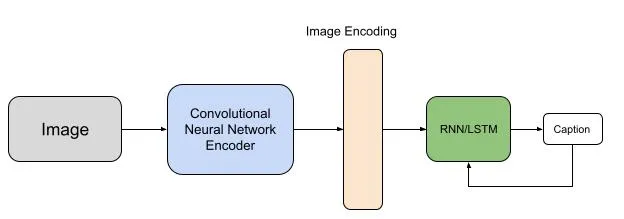

**The CNN:** Typically, the CNN tends to be the least computationally intensive/complex part of this model architecture. Why? Because most image captioning models tend to use transfer learning to simply load pre-trained weights of already existing powerful CNN architectures. In this example, using the Inception V3 CNN network that will be loaded in Pytorch’s torchvision library. It doesn’t require the CNN to learn very specific things (the only purpose of the CNN is to create a rich embedding for the image). Any features that the model have to learn that are beneficial for image captioning learned during the training process for the whole model, and its weights have fine-tuned.



### **Here is the Pytorch model code for the CNN Encoder:**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
class CNNEncoder(nn.Module):
 def __init__(self, embed_size):
   super(CNNEncoder, self).__init__()
   self.inception = models.inception_v3(pretrained=True,
                                       aux_logits=False)
   self.inception.fc = nn.Linear(self.inception.fc.in_features,
                                                    embed_size)
   self.relu = nn.ReLU()
   self.dropout = nn.Dropout(0.5)
 def forward(self, input):
   features = self.inception(input)
   return self.dropout(self.relu(features))

it is a relatively straightforward CNN architecture. The only difference is that we are taking the last fully connected layer of the Inception network, and manually changing it to map/connect to the embedding size we want our feature embeddings to be (and the size that the RNN decoder will take in as input).

**The RNN Decoder:** Unlike CNN’s, typically do not use transfer learning in RNN’s/LSTM’s. The inputs to the LSTM are usually just the hidden state from the previous cell, and the output of the previous LSTM cell. However, for this model, we will concatenate the feature embedding produced by the CNN with the previous output of the LSTM, and pass this concatenated tensor into the LSTM. 

#### **Here is the Pytorch code for the LSTM:**

In [ ]:
class DecoderRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size):
    super(DecoderRNN, self).__init__()
    self.embed = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size)
    self.linear = nn.Linear(hidden_size, vocab_size)
    self.dropout = nn.Dropout(0.5)
  def forward(self, features, captions):
    embeddings = self.dropout(self.embed(captions))
    embeddings = torch.cat((features.unsqueeze(0), embeddings), 
                                                        dim=0)
    hiddens, _ = self.lstm(embeddings)
    outputs = self.linear(hiddens)
    return outputs

The vocab size is a parameter will have to calculate based on what dataset used. In the model code above, like with many/most LSTM architectures, to actually get the word that each cell predicts, I use a linear layer that takes the hidden layer and maps it to the vocab. in the LSTM code, use an nn.Embedding layer that will take the one-hot encodings of each word in the vocab and transform them into an embedding of embed_size. Nowadays, we typically don’t generate word embeddings from scratch (for instance many people just use transformer weights) because this prolongs the training process, but because we are using an LSTM as our decoder, we can’t really load pre-trained weights and use them.

In [ ]:
class Encoder_Decoder(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size):
    super(Encoder_Decoder, self).__init__()
    self.cnn = CNNEncoder(embed_size)
    self.decoderRNN = DecoderRNN(embed_size, hidden_size,
                                 vocab_size)
  def forward(self, images, captions):
    features = self.cnn(images)
    outputs = self.decoderRNN(features, captions)
    return outputs

simply connect both models by feeding the output of the CNN as input to the Decoder LSTM, and return the final output of the LSTM. This final Encoder_Decoder model is the actual model we will train on our data (not the other 2).

####**Modifications to the Encoder-Decoder Model**

While the model architecture described above is already a good way to construct image captioning models, there are a couple of ways to modify the model to make it more powerful.

Attention Mechanism: At a high level, as the Decoder generates each word of the caption, an attention mechanism allows a model to pay attention to — or essentially focus on — relevant parts of the image. For instance, taking the example of a dog running on water, when the decoder captions the word ‘dog’, an attention mechanism would then allow the model to focus on the spatial region of the image that contained the dog.

There are 2 types of attention mechanisms could use:

**Soft Attention:** Soft attention involves constructing a word by considering/paying attention to multiple parts of an image — each to a different degree. Basically, just  it as using — sometimes many — different parts of an image each with different strengths. Certain parts of an image will be considered more strongly than other parts of the image.

**Hard Attention:** Hard attention involves considering multiple parts of an image, but in contrast to soft attention, each part of the image that is considered has the same strength. In other words, each part of the image that is selected (i.e that the model is ‘paying attention to’) is completely considered, and the parts of the image not selected are completely disregarded while generating a specific word.

Before we feed the feature embedding produced by the CNN to the decoder, to add the attention mechanism, add a separate linear/attention layer that we will apply to the feature embedding. Below is some pseudo-code/Pytorch code demonstrating soft attention:

In [ ]:
self.attention = nn.Linear(embed_size, embed_size)
self.softmax = nn.Softmax()
attention_output = self.softmax(self.attention(feature_embedding))
feature_embedding = feature_embedding * attention_output

The softmax is used to create the probability distributions for the feature embedding. Multiplying these probabilities with the original feature embedding will produce the new embedding layer that will feed to the decoder.

#### **Sourse :** https://towardsdatascience.com/how-to-build-an-image-captioning-model-in-pytorch-29b9d8fe2f8c